In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim, flatten
from torch.nn import Linear, Conv2d, MaxPool2d, BatchNorm2d, Module, Dropout, ReLU
import torch.nn.functional as F
import random
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
def data_loader(batch_size):
    transform = transforms.Compose([transforms.RandomRotation(15),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,)),])
    
    valid_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,)),])
    
    trainset = datasets.MNIST('./', download=True, train=True,  transform=transform)
    testset = datasets.MNIST('./', download=True, train=False, transform=valid_transforms)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
    
    return trainloader, testloader, trainset, testset

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = Conv2d(1,16, kernel_size=3,stride=1,padding=1)
        self.pool = MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = Conv2d(16,32, kernel_size=3,stride=1,padding=1)
        self.fc1 = nn.Linear(32*7*7,1000)
        self.fc2 = nn.Linear(1000,500)
        self.fc3 = nn.Linear(500,124)
        self.fc4 = nn.Linear(124,10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x) 
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        #x = F.log_softmax(self.fc3(x), dim=1)       
        return x

In [7]:
batch_sizes = [64,192,250,320,448,576,704,832,960,1024,1500,2000,3000,4000]

In [8]:
def train(model, loss_fn, optimizer, epoch, batch_size, j):
    model.to(device)
    step = 0
    params = sum([p.numel() for p in model.parameters()])
    trainloader, testloader, trainset, testset = data_loader(batch_size)
    print(f'\n===========================Model{str(j+1)}  Batch_Size: {batch_size}==============================')
    #print("Batch Size: ", batch_size, "Data Length: ", len(trainloader))
    for e in range(epoch):     
        model.train()
        train_loss = 0
        trainacc=0
        for images, labels in trainloader:
            step+=1
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            logps = model(images) #forward propagation
            loss = loss_fn(logps, labels) #calculate loss
            train_loss+=loss.item()
            
            _, pred = logps.max(1)
            trainacc += (pred == labels).sum()
            
            loss.backward() #backward propagation
            
            counter = 0
            fNormAll = 0
            for i, p in enumerate(model.parameters()):
                grad = 0.0
                if p.grad is not None:
                    grad = p.grad
                    fNorm = torch.linalg.norm(grad).cpu().numpy()
                    fNormAll += fNorm
            sensitivity=(fNormAll/i)
            
            optimizer.step() #update weights
            
        tloss = train_loss/len(trainloader)
        trainaccr = trainacc/len(trainset)
        with torch.no_grad():
            valloss = 0
            acc = 0
            model.eval()
            for img, label in testloader:
                img, label = img.to(device), label.to(device)
                logps = model(img) #forward propagation
                loss = loss_fn(logps, label) #calculate loss
                valloss+=loss.item()
                _, pred = logps.max(1)
                acc += (pred == label).sum()
            vloss = valloss/len(testloader)
            vaccr = acc/len(testset)
        
    print(f"TrainLoss:{tloss:.4f} TrainAcc:{trainaccr.item():.2f}, ValLoss:{vloss:.4f} ValAcc:{vaccr.item():.2f}")
    return tloss, round(trainaccr.item(),2), vloss, round(vaccr.item(),2), round(sensitivity,3)

In [9]:
epoch = 8
trainloss_list = []
trainacc_list = []
testloss_list = []
testacc_list = []
sensitivitylist = []
for i in range(len(batch_sizes)):
    #print(f'\n=====================Model{str(i)}=====================')
    model = CNN()
    optimizer = optim.Adam(model.parameters(), lr=0.00001)
    loss_fn = nn.NLLLoss()
    tloss, trainaccr, vloss, vaccr, sensitivity = train(model, loss_fn, optimizer, epoch, batch_sizes[i], i)
    trainloss_list.append(tloss)
    trainacc_list.append(trainaccr)
    testloss_list.append(vloss)
    testacc_list.append(vaccr)
    sensitivitylist.append(sensitivity)


===========================Model1  Batch_Size: 64==============================
TrainLoss:0.4116 TrainAcc:0.87, ValLoss:0.3233 ValAcc:0.90

===========================Model2  Batch_Size: 192==============================
TrainLoss:0.5696 TrainAcc:0.82, ValLoss:0.4803 ValAcc:0.85

===========================Model3  Batch_Size: 250==============================
TrainLoss:0.6259 TrainAcc:0.80, ValLoss:0.5344 ValAcc:0.83

===========================Model4  Batch_Size: 320==============================
TrainLoss:0.6216 TrainAcc:0.80, ValLoss:0.5302 ValAcc:0.83

===========================Model5  Batch_Size: 448==============================
TrainLoss:0.7927 TrainAcc:0.76, ValLoss:0.7080 ValAcc:0.78

===========================Model6  Batch_Size: 576==============================
TrainLoss:0.8831 TrainAcc:0.73, ValLoss:0.7915 ValAcc:0.76

===========================Model7  Batch_Size: 704==============================
TrainLoss:0.8935 TrainAcc:0.74, ValLoss:0.7982 ValAcc:0.77

=============

In [12]:
print(sensitivitylist)

[0.04812121080149981, 0.23288072950460695, 0.6119662846692584, 1.2219522697004406, 0.712974987924099, 0.3461852508004416, 1.2060424296016043, 0.8510614423589273, 1.2922366843982176, 0.28995760157704353, 0.3774390509352088, 0.7299684008414095, 0.287856091406535, 0.37539736918089067]


Text(0.5, 1.0, 'Batch Size VS Loss and Sensitivity')

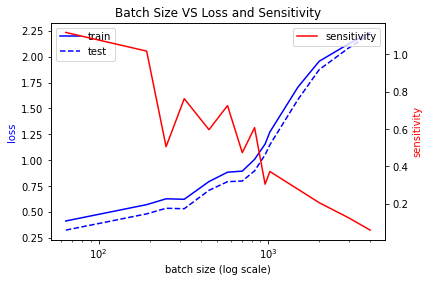

In [10]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(batch_sizes, trainloss_list, 'b', label='train')
ax1.plot(batch_sizes, testloss_list, 'b--', label='test')
ax2.plot(batch_sizes, sensitivitylist, 'r', label='sensitivity')
ax1.set_xlabel('batch size (log scale)')
ax1.set_xscale('log')
ax1.set_ylabel('loss', color='b')
ax2.set_ylabel('sensitivity', color='r')
ax1.legend()
ax2.legend(loc='upper right')
ax1.set_title('Batch Size VS Loss and Sensitivity')
#fig.savefig('sensitivityLoss.png')

Text(0.5, 1.0, 'Batch Size vs Accuracy and Sensitivity')

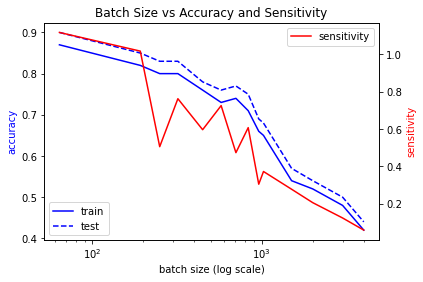

In [11]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(batch_sizes, trainacc_list, 'b', label='train')
ax1.plot(batch_sizes, testacc_list, 'b--', label='test')
ax2.plot(batch_sizes, sensitivitylist, 'r', label='sensitivity')
ax1.set_xlabel('batch size (log scale)')
ax1.set_xscale('log')
ax1.set_ylabel('accuracy', color='b')
ax2.set_ylabel('sensitivity', color='r')
ax1.legend()
ax1.legend(loc='lower left')
ax2.legend(loc='upper right')
ax1.set_title('Batch Size vs Accuracy and Sensitivity')
#fig.savefig('sensitivityAccuracy.png')